# Generative Adversarial Networks: Generating Graphene EM Images

In [07_VAE_practical.ipynb](07_VAE_practical.ipynb), we have used the inelastic neutron scattering (INS) dataset to train a VAE to generate new images. In this notebook, we train a GAN with the same dataset.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

Using TensorFlow v2.4.1


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    data_path = './sciml-workshop-data/'
    

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

OK
48 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 48 not upgraded.
Need to get 10.7 MB of archives.
After this operation, 22.9 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.33.1_amd64.deb ...
Unpacking gcsfuse (0.33.1) ...
Setting up gcsfuse (0.33.1) ...
Using mount point: /content/sciml-workshop-data
Opening GCS connection...
Mounting file system...
File system has been successfully mounted.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1974  100  1974    0     0  56400      0 --:--:-- --:--:-- --:--:-- 58058




Updated property [core/project].


---

# The dataset

The INS dataset contains 20,000 images. This number is insufficient to train a GAN, given that the images are of high variability. Each image has a shape of `(20, 200)`, as composed of 10 images with shape `(20, 20)` in a row. To maximise the number of data, we divide one original image into 10 sub-images and filter out the weak ones. Finally, we obtain a dataset with 129,228 images.

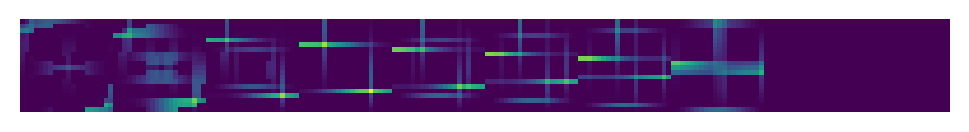

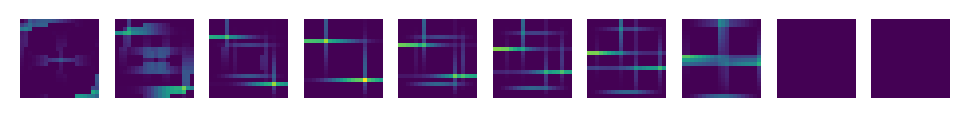

Shape of original dataset: (20000, 20, 200, 1)
Shape of divided dataset: (200000, 20, 20, 1)
Shape of training dataset: (129228, 20, 20, 1)


In [4]:
# read original images
with h5py.File(data_path + 'ins-data/train.h5', 'r') as handle:
    big_images = handle['images'][:]
    
# divide into 10 sub-images
n = big_images.shape[0]
sub_images = np.moveaxis(big_images.reshape([n, 20, 10, 20]), 2, 1).reshape(n * 10, 20, 20, 1)
    
# plot an image and its sub-images
index = 0
plt.figure(dpi=200)
plt.imshow(big_images[index, :, :, 0])
plt.gca().set_aspect(1.)
plt.axis('off')
plt.show()
fig, ax = plt.subplots(1, 10, dpi=200)
for i in range(10):
    ax[i].imshow(sub_images[index * 10 + i, :, :, 0], vmin=0, vmax=1)
    ax[i].set_aspect(1.)
    ax[i].axis('off')
plt.show()

# remove weak ones: max pixel smaller than a given threshold
threshold = 0.5
train_images = sub_images[np.where(np.max(sub_images, axis=(1, 2, 3)) > threshold)]

# normalize to [-1, 1]
train_images = train_images * 2 - 1

# print size info
print(f'Shape of original dataset: {big_images.shape}')
print(f'Shape of divided dataset: {sub_images.shape}')
print(f'Shape of training dataset: {train_images.shape}')

Next, we can create a dataset with the new image set:

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(256)

---

# Create a GAN

Our image size is `(20, 20)`, similar to `mnist`, so we may continue to use the network designed in [08_GAN_basics.ipynb](08_GAN_basics.ipynb). 


### The generator

Create a generator network. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb), only changing the image size.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
def make_generator_model(noise_size=100, image_size=(28,28), n_filters=(256,128,64)):
    '''
    Create a generator, hardcoded with three Conv2DTranspose layers.
    
    :param noise_size: size of the seed vector
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the generator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Dense
    # input shape: (100,)
    # output shape: (7*7*256,)
    w = image_size[0] // 4
    h = image_size[1] // 4
    model.add(layers.Dense(w*h*n_filters[0], use_bias=False, 
                           input_shape=(noise_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape
    # input shape: (7*7*256,)
    # output shape: (7, 7, 256)
    model.add(layers.Reshape((w, h, n_filters[0])))

    # Conv2DTranspose
    # input shape: (7, 7, 256)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2DTranspose(n_filters[1], (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (7, 7, 128)
    # output shape: (14, 14, 64)
    model.add(layers.Conv2DTranspose(n_filters[2], (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (14, 14, 64)
    # output shape: (28, 28, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, activation='tanh'))
    
    # input: (100,)
    # output: (28, 28, 1)
    return model

# noise size
NOISE_SIZE = 100

# create a generator
generator = make_generator_model(noise_size=NOISE_SIZE, image_size=(20, 20), 
                                 n_filters=(256,128,64))
```
    
</p>
</details>


In [6]:
def make_generator_model(noise_size=100, image_size=(28,28), n_filters=(256,128,64)):
    '''
    Create a generator, hardcoded with three Conv2DTranspose layers.
    
    :param noise_size: size of the seed vector
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the generator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Dense
    # input shape: (100,)
    # output shape: (7*7*256,)
    w = image_size[0] // 4
    h = image_size[1] // 4
    model.add(layers.Dense(w*h*n_filters[0], use_bias=False, 
                           input_shape=(noise_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape
    # input shape: (7*7*256,)
    # output shape: (7, 7, 256)
    model.add(layers.Reshape((w, h, n_filters[0])))

    # Conv2DTranspose
    # input shape: (7, 7, 256)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2DTranspose(n_filters[1], (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (7, 7, 128)
    # output shape: (14, 14, 64)
    model.add(layers.Conv2DTranspose(n_filters[2], (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose
    # input shape: (14, 14, 64)
    # output shape: (28, 28, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, activation='tanh'))
    
    # input: (100,)
    # output: (28, 28, 1)
    return model

# noise size
NOISE_SIZE = 100

# create a generator
generator = make_generator_model(noise_size=NOISE_SIZE, image_size=(20, 20), 
                                 n_filters=(256,128,64))

### The discriminator

Create a discriminator network. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb), only changing the image size.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
def make_discriminator_model(image_size=(28,28), n_filters=(64,128)):
    '''
    Create a discriminator, hardcoded with two Conv2D layers.
    
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the discriminator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Conv2D
    # input shape: (28, 28, 1)
    # output shape: (14, 14, 64)
    w = image_size[0]
    h = image_size[1]
    model.add(layers.Conv2D(n_filters[0], (5, 5), strides=(2, 2), padding='same',
              input_shape=[w, h, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Conv2D
    # input shape: (14, 14, 64)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2D(n_filters[1], (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten
    # input shape: (7, 7, 128)
    # output shape: (7*7*128,)
    model.add(layers.Flatten())
    
    # 4th layer: Dense
    # input shape: (7*7*128,)
    # output shape: (1,)
    model.add(layers.Dense(1))
    
    # input: (28, 28, 1)
    # output: (1,)
    return model

# create a discriminator
discriminator = make_discriminator_model(image_size=(20, 20), n_filters=(64,128))
```
    
</p>
</details>

In [7]:
def make_discriminator_model(image_size=(28,28), n_filters=(64,128)):
    '''
    Create a discriminator, hardcoded with two Conv2D layers.
    
    :param image_size: size of the image (both width and height must divide 4)
    :param n_filters: number of filters in each layer
    :return: the discriminator model
    '''
    
    # sequential model
    model = tf.keras.Sequential()
    
    # Conv2D
    # input shape: (28, 28, 1)
    # output shape: (14, 14, 64)
    w = image_size[0]
    h = image_size[1]
    model.add(layers.Conv2D(n_filters[0], (5, 5), strides=(2, 2), padding='same',
              input_shape=[w, h, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Conv2D
    # input shape: (14, 14, 64)
    # output shape: (7, 7, 128)
    model.add(layers.Conv2D(n_filters[1], (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten
    # input shape: (7, 7, 128)
    # output shape: (7*7*128,)
    model.add(layers.Flatten())
    
    # 4th layer: Dense
    # input shape: (7*7*128,)
    # output shape: (1,)
    model.add(layers.Dense(1))
    
    # input: (28, 28, 1)
    # output: (1,)
    return model

# create a discriminator
discriminator = make_discriminator_model(image_size=(20, 20), n_filters=(64,128))

### Loss functions and optimizers

Create the loss functions and optimizers for the generator and discriminator. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb) without changing anything.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# cross entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator's loss 
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator's loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
```
    
</p>
</details>

In [8]:
# cross entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator's loss 
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator's loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

---

# Training Loop

Implement the training function for a mini-batch. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb) without changing anything.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_images, noise_size):
    # seed
    batch_size = real_images.shape[0]
    seed = tf.random.normal([batch_size, noise_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # fake images
        fake_images = generator(seed, training=True)
        
        # discriminate real
        real_score = discriminator(real_images, training=True)
        # discriminate fake
        fake_score = discriminator(fake_images, training=True)

        # compute losses
        gen_loss = generator_loss(fake_score)
        disc_loss = discriminator_loss(real_score, fake_score)
        
        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # apply gradients to update model parameters
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
        
        return gen_loss, disc_loss
```
    
</p>
</details>


In [9]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_images, noise_size):
    # seed
    batch_size = real_images.shape[0]
    seed = tf.random.normal([batch_size, noise_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # fake images
        fake_images = generator(seed, training=True)
        
        # discriminate real
        real_score = discriminator(real_images, training=True)
        # discriminate fake
        fake_score = discriminator(fake_images, training=True)

        # compute losses
        gen_loss = generator_loss(fake_score)
        disc_loss = discriminator_loss(real_score, fake_score)
        
        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # apply gradients to update model parameters
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
        
        return gen_loss, disc_loss

Now perform the training. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb) without changing anything.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
############################
######### TRAINING #########
############################

# epochs
EPOCHS = 50

# epoch loop
tstart = time.time()
for epoch in range(EPOCHS):
    # batch loop
    for i, image_batch in enumerate(train_dataset):
        gen_loss, disc_loss = train_step(image_batch, NOISE_SIZE)
    # print loss after each epoch
    print(f'Epoch {epoch + 1} / {EPOCHS}, Elapsed = {time.time() - tstart:.2f} s, '
          f'Gen loss = {gen_loss:.2f}, Disc loss = {disc_loss:.2f}')
```
    
</p>
</details>

In [10]:
############################
######### TRAINING #########
############################

# epochs
EPOCHS = 50

# epoch loop
tstart = time.time()
for epoch in range(EPOCHS):
    # batch loop
    for i, image_batch in enumerate(train_dataset):
        gen_loss, disc_loss = train_step(image_batch, NOISE_SIZE)
    # print loss after each epoch
    print(f'Epoch {epoch + 1} / {EPOCHS}, Elapsed = {time.time() - tstart:.2f} s, '
          f'Gen loss = {gen_loss:.2f}, Disc loss = {disc_loss:.2f}')

Epoch 1 / 50, Elapsed = 21.75 s, Gen loss = 0.71, Disc loss = 1.42
Epoch 2 / 50, Elapsed = 35.02 s, Gen loss = 0.84, Disc loss = 1.16
Epoch 3 / 50, Elapsed = 48.49 s, Gen loss = 0.86, Disc loss = 1.18
Epoch 4 / 50, Elapsed = 62.18 s, Gen loss = 1.15, Disc loss = 0.85
Epoch 5 / 50, Elapsed = 76.02 s, Gen loss = 1.05, Disc loss = 0.98
Epoch 6 / 50, Elapsed = 89.71 s, Gen loss = 1.28, Disc loss = 0.85
Epoch 7 / 50, Elapsed = 103.24 s, Gen loss = 1.24, Disc loss = 0.88
Epoch 8 / 50, Elapsed = 116.72 s, Gen loss = 1.30, Disc loss = 0.87
Epoch 9 / 50, Elapsed = 130.22 s, Gen loss = 1.15, Disc loss = 0.96
Epoch 10 / 50, Elapsed = 143.81 s, Gen loss = 1.31, Disc loss = 0.75
Epoch 11 / 50, Elapsed = 157.46 s, Gen loss = 1.24, Disc loss = 0.97
Epoch 12 / 50, Elapsed = 171.12 s, Gen loss = 1.29, Disc loss = 0.97
Epoch 13 / 50, Elapsed = 184.73 s, Gen loss = 1.29, Disc loss = 0.97
Epoch 14 / 50, Elapsed = 198.32 s, Gen loss = 1.17, Disc loss = 1.04
Epoch 15 / 50, Elapsed = 211.90 s, Gen loss = 1.1

Finally, use the trained generator to generate images from random noise. In the suggested answer, we simply copy from [08_GAN_basics.ipynb](08_GAN_basics.ipynb). 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# seed
nrows = 10
ncols = 10
seed = tf.random.normal([nrows * ncols, NOISE_SIZE])

# generate images
generated_image = generator(seed, training=False)

# plot images
plt.figure(dpi=100, figsize=(ncols, nrows))
for iplot in range(nrows * ncols):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(generated_image[iplot, :, :, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()
```
    
</p>
</details>

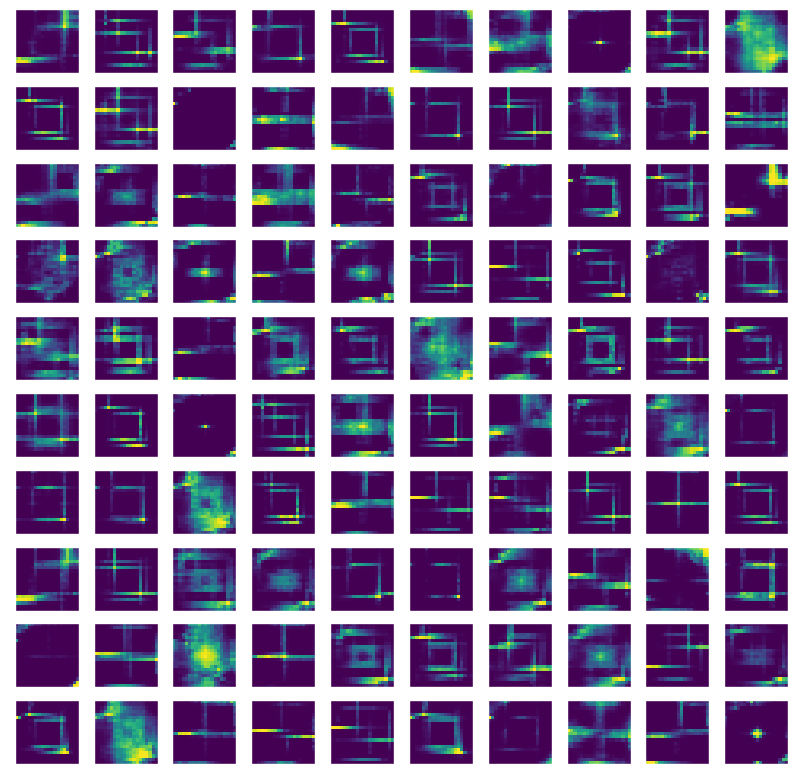

In [12]:
# seed
nrows = 10
ncols = 10
seed = tf.random.normal([nrows * ncols, NOISE_SIZE])

# generate images
generated_image = generator(seed, training=False)

# plot images
plt.figure(dpi=100, figsize=(ncols, nrows))
for iplot in range(nrows * ncols):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(generated_image[iplot, :, :, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()

Compare the generated results to those generated by a VAE in [07_VAE_practical.ipynb](07_VAE_practical.ipynb). What can you find?